## Geospatial visualization in Maps

Objective: 

Analyse and visualize the geospatial data in maps.

In specific, visualize the distribution of villages of India from Census data along with the population metrics.

Steps:

1. Create a new environment to install geo-libraries
1. Import libraries
1. Load shapefile for a state from Census India data
1. Load csvfile containing coordinates
1. Visualization
    1. Using shapefile
    1. Using geodataframe
    1. Using csvfile
    1. Using layers
    1. With colors

Data source download links: 
1. Collection: India Village-Level Geospatial Socio-Economic Data Set - University of Texas Libraries GeoData Search Results (utexas.edu) - https://geodata.lib.utexas.edu/?f%5Bdct_isPartOf_sm%5D%5B%5D=India+Village-Level+Geospatial+Socio-Economic+Data+Set
1. India Village-Level Geospatial Socio-Economic Data Set, v1: India Data Collection | SEDAC (columbia.edu) - https://sedac.ciesin.columbia.edu/data/set/india-india-village-level-geospatial-socio-econ-1991-2001  (Requires login)

Data dictionary for columns:
https://sedac.ciesin.columbia.edu/downloads/docs/india/india-india-village-level-geospatial-socio-econ-1991-2001-documentation.pdf

Note: Map Ouputs in below codes are shown as images for reference. 

#### Create a new environment to install geo-libraries - geopandas & leafmap

In [ ]:
conda create geo -n python=3.8
conda activate geo
conda install geopandas
conda install mamba -c conda-forge
mamba install leafmap -c conda-forge

In [2]:
pip install leafmap

#### Import libraries 

In [46]:
# General libraries
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Geo-libraries
import geopandas as gpd
import rtree
import pyproj
import fiona
import shapely
import leafmap
import leafmap.foliumap as leafmap
import leafmap.leafmap as leafmap

#### Load shapefile for a state from Census India data

In [5]:
# Read shapefile
p = gpd.read_file('../Data/TN/india-village-census-2001-TN.shp')

In [6]:
# Convert to coordinate system 
p = p.to_crs(epsg=4326)

In [7]:
df_c = p[['UID', 'NAME', 'STATE', 'DISTRICT', 'SUB_DIST', 'VILL_CODE', 'TOWN_VILL','LEVEL', 'NAME_1', 'TRU', 'geometry', 'No_HH', 'TOT_P', 'TOT_M', 'TOT_F']]

In [11]:
# Population buckets 10, 5L-10L, 2L-5L, 1L-2L, 50k-1L, 25k-50k , 10k-25k, 5k-10k, <5k

conditions = [df_c['TOT_P'] > 1000000,
              (df_c['TOT_P'] <= 1000000) & (df_c['TOT_P'] > 500000),
              (df_c['TOT_P'] <= 500000) & (df_c['TOT_P'] > 200000),
              (df_c['TOT_P'] <= 200000) & (df_c['TOT_P'] > 100000),
              (df_c['TOT_P'] <= 100000) & (df_c['TOT_P'] > 50000),
              (df_c['TOT_P'] <= 50000) & (df_c['TOT_P'] > 25000),
              (df_c['TOT_P'] <= 25000) & (df_c['TOT_P'] > 10000),
              (df_c['TOT_P'] <= 10000) & (df_c['TOT_P'] > 5000),
              df_c['TOT_P'] <= 5000
             ]

choices = ['>10L','5L-10L','2L-5L','1L-2L','50k-1L','25k-50k','10k-25k','5k-10k','<5k']
 
df_c['Population'] = np.select(conditions, choices, default= df_c['TOT_P'] )

In [12]:
df_c.head()

UID          NAME  STATE  DISTRICT  SUB_DIST VILL_CODE  TOWN_VILL  \
0  609637     Karimanal     33         1         2  00008800       8800   
1  609638    Arambakkam     33         1         1  00000300        300   
2  609639    Egumadurai     33         1         1  00000100        100   
3  609640   Naidukuppam     33         1         1  00000200        200   
4  609641  Kannambakkam     33         1         1  00000500        500   

     LEVEL           NAME_1    TRU  \
0     None  KARIMANAL  (UI)   None   
1  VILLAGE       Arambakkam  Rural   
2  VILLAGE       Egumadurai  Rural   
3  VILLAGE      Naidukuppam  Rural   
4  VILLAGE     Kannambakkam  Rural   

                                            geometry  No_HH  TOT_P  TOT_M  \
0  POLYGON ((80.26843 13.56393, 80.26915 13.56311...      0      0      0   
1  POLYGON ((80.03970 13.53863, 80.03973 13.53863...   1810   8475   4183   
2  POLYGON ((80.02533 13.54443, 80.02442 13.54222...    275   1087    544   
3  POLYGON ((80.02533 13.54443, 80.02968 13.53999...     67    320    159   
4  POLYGON ((80.02955 13.51974, 80.02998 13.51947...    264   1018    509   

   TOT_F Population  
0      0        <5k  
1   4292     5k-10k  
2    543        <5k  
3    161        <5k  
4    509        <5k

#### Load CSV file containing xy coordinates

In [37]:
in_csv = "../Data/CoimatoreVillagesWithLatLong.csv"
df_cb = pd.read_csv(in_csv)
df_cb

Town-Village    Level              Name  TOT_P  TOT_M  TOT_F    District  \
0          644340  VILLAGE  Chinnakallipatti   3858   1958   1900  Coimbatore   
1          644341  VILLAGE        Muduthurai   4394   2233   2161  Coimbatore   
2          644342  VILLAGE         Irumborai   8001   3974   4027  Coimbatore   
3          644343  VILLAGE     Illuppanatham   9255   4569   4686  Coimbatore   
4          644344  VILLAGE      Bellapalayam   9131   4606   4525  Coimbatore   
..            ...      ...               ...    ...    ...    ...         ...   
232        644586  VILLAGE      Kambalapatti   5380   2705   2675  Coimbatore   
233        644587  VILLAGE  Arthanaripalayam   3233   1633   1600  Coimbatore   
234        644588  VILLAGE        Jallipatti   2511   1216   1295  Coimbatore   
235        644589  VILLAGE          Thorayur    510    255    255  Coimbatore   
236        644590  VILLAGE     Angalakurichi   8816   4342   4474  Coimbatore   

                         Address       long        lat  
0    Chinnakallipatti,Coimbatore  77.108701  11.385853  
1          Muduthurai,Coimbatore  77.131014  11.350817  
2           Irumborai,Coimbatore  77.064411  11.371630  
3       Illuppanatham,Coimbatore  77.020339  11.331213  
4        Bellapalayam,Coimbatore  77.007305  11.319059  
..                           ...        ...        ...  
232      Kambalapatti,Coimbatore  77.037016  10.552347  
233  Arthanaripalayam,Coimbatore  77.062161  10.536575  
234        Jallipatti,Coimbatore  77.027660  10.525110  
235          Thorayur,Coimbatore  77.013264  10.543788  
236     Angalakurichi,Coimbatore  76.994547  10.533374  

[237 rows x 10 columns]

In [24]:
df_cb.columns

Index(['Town-Village', 'Level', 'Name', 'TOT_P', 'TOT_M', 'TOT_F', 'District',
       'Address', 'long', 'lat'],
      dtype='object')

In [38]:
df_cb = gpd.GeoDataFrame(df_cb, geometry=gpd.points_from_xy(df_cb.long, df_cb.lat),crs=4326)

In [27]:
df_cb.head()

Town-Village    Level              Name  TOT_P  TOT_M  TOT_F    District  \
0        644340  VILLAGE  Chinnakallipatti   3858   1958   1900  Coimbatore   
1        644341  VILLAGE        Muduthurai   4394   2233   2161  Coimbatore   
2        644342  VILLAGE         Irumborai   8001   3974   4027  Coimbatore   
3        644343  VILLAGE     Illuppanatham   9255   4569   4686  Coimbatore   
4        644344  VILLAGE      Bellapalayam   9131   4606   4525  Coimbatore   

                       Address       long        lat  \
0  Chinnakallipatti,Coimbatore  77.108701  11.385853   
1        Muduthurai,Coimbatore  77.131014  11.350817   
2         Irumborai,Coimbatore  77.064411  11.371630   
3     Illuppanatham,Coimbatore  77.020339  11.331213   
4      Bellapalayam,Coimbatore  77.007305  11.319059   

                    geometry  
0  POINT (77.10870 11.38585)  
1  POINT (77.13101 11.35082)  
2  POINT (77.06441 11.37163)  
3  POINT (77.02034 11.33121)  
4  POINT (77.00730 11.31906)

#### Visualization

1. Visualization using shapefile
1. Visualization using geodataframe
1. Visualization using csvfile
1. Visualization with layers
1. Visualization with colors based on values

In [ ]:
# Shapefile
in_shp = '../Data/TN/india-village-census-2001-TN.shp'

In [19]:
# Geodataframe from shapefile
df_c.head()

UID          NAME  STATE  DISTRICT  SUB_DIST VILL_CODE  TOWN_VILL  \
0  609637     Karimanal     33         1         2  00008800       8800   
1  609638    Arambakkam     33         1         1  00000300        300   
2  609639    Egumadurai     33         1         1  00000100        100   
3  609640   Naidukuppam     33         1         1  00000200        200   
4  609641  Kannambakkam     33         1         1  00000500        500   

     LEVEL           NAME_1    TRU  \
0     None  KARIMANAL  (UI)   None   
1  VILLAGE       Arambakkam  Rural   
2  VILLAGE       Egumadurai  Rural   
3  VILLAGE      Naidukuppam  Rural   
4  VILLAGE     Kannambakkam  Rural   

                                            geometry  No_HH  TOT_P  TOT_M  \
0  POLYGON ((80.26843 13.56393, 80.26915 13.56311...      0      0      0   
1  POLYGON ((80.03970 13.53863, 80.03973 13.53863...   1810   8475   4183   
2  POLYGON ((80.02533 13.54443, 80.02442 13.54222...    275   1087    544   
3  POLYGON ((80.02533 13.54443, 80.02968 13.53999...     67    320    159   
4  POLYGON ((80.02955 13.51974, 80.02998 13.51947...    264   1018    509   

   TOT_F Population  
0      0        <5k  
1   4292     5k-10k  
2    543        <5k  
3    161        <5k  
4    509        <5k

In [39]:
# Geodataframe from csvfile
df_cb.head()

Town-Village    Level              Name  TOT_P  TOT_M  TOT_F    District  \
0        644340  VILLAGE  Chinnakallipatti   3858   1958   1900  Coimbatore   
1        644341  VILLAGE        Muduthurai   4394   2233   2161  Coimbatore   
2        644342  VILLAGE         Irumborai   8001   3974   4027  Coimbatore   
3        644343  VILLAGE     Illuppanatham   9255   4569   4686  Coimbatore   
4        644344  VILLAGE      Bellapalayam   9131   4606   4525  Coimbatore   

                       Address       long        lat  \
0  Chinnakallipatti,Coimbatore  77.108701  11.385853   
1        Muduthurai,Coimbatore  77.131014  11.350817   
2         Irumborai,Coimbatore  77.064411  11.371630   
3     Illuppanatham,Coimbatore  77.020339  11.331213   
4      Bellapalayam,Coimbatore  77.007305  11.319059   

                    geometry  
0  POINT (77.10870 11.38585)  
1  POINT (77.13101 11.35082)  
2  POINT (77.06441 11.37163)  
3  POINT (77.02034 11.33121)  
4  POINT (77.00730 11.31906)

<AxesSubplot:>

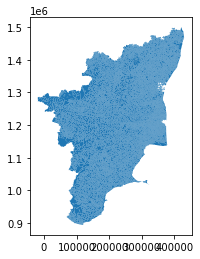

In [20]:
# Simple plot using matplotlib
p = gpd.read_file(in_shp)
p.plot()

**1. Add a shapefile to the map**

In [ ]:
m = leafmap.Map(center=[0, 0], zoom=2)
m.add_shp(in_shp, layer_name="Villages boundaries")

In [ ]:
#m

**2. Add a GeoDataFrame to the map**

In [14]:
n = leafmap.Map(center=[0, 0], zoom=2)
n.add_gdf(df_c, layer_name="Villages boundaries")

In [ ]:
#n

Geodataframe & shapefile produce same output

In [ ]:
# Sample output is shown as image

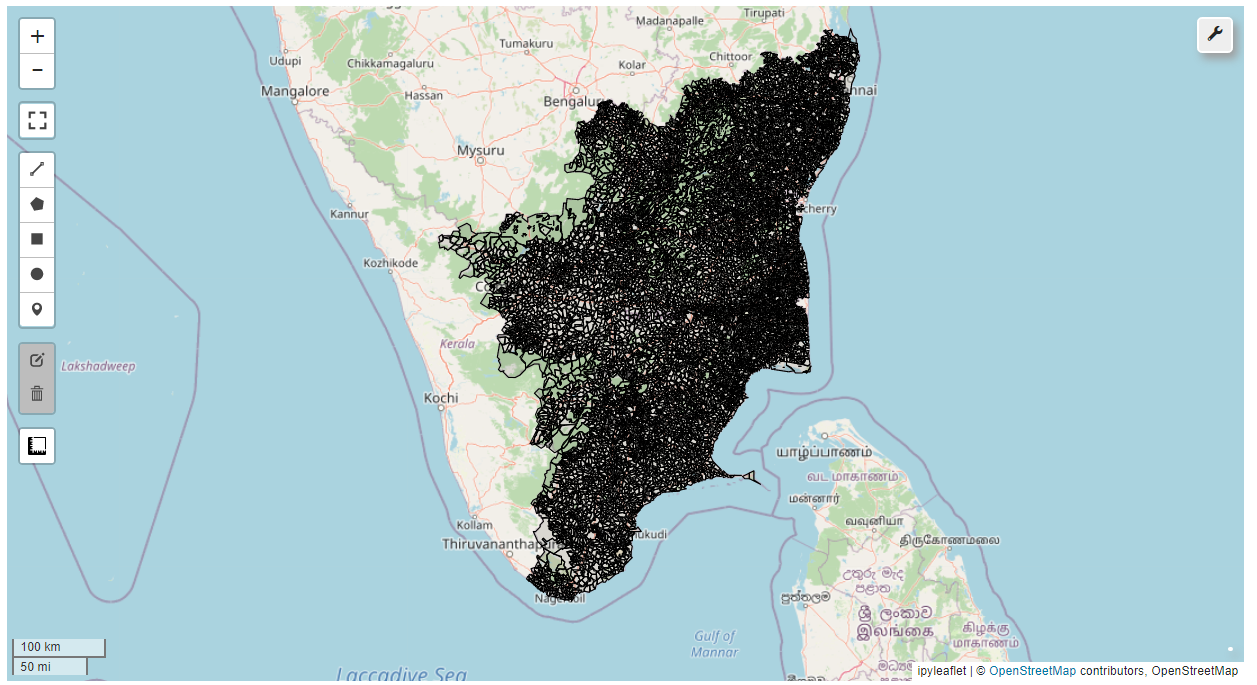

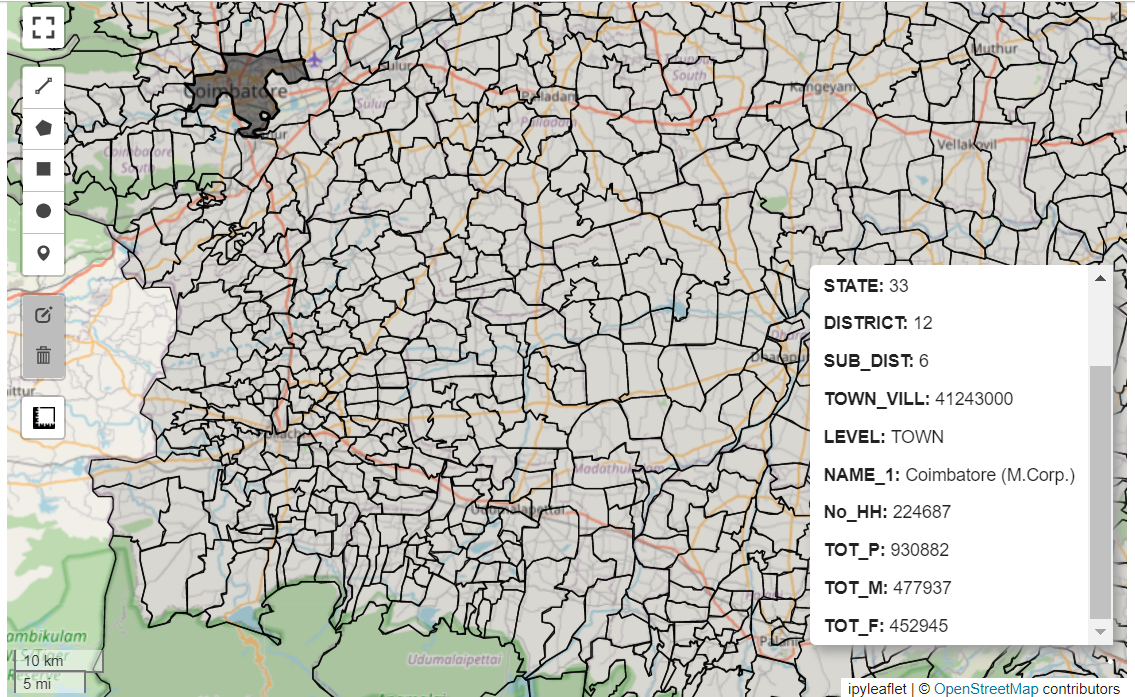

**3. Add csv file to the map**

**3.1 As points**

In [30]:
c = leafmap.Map(center=[0, 0], zoom=2)
c.add_gdf(df_cb, layer_name="Coimbatore Villages")

In [ ]:
#c

In [ ]:
# Sample output is shown as image

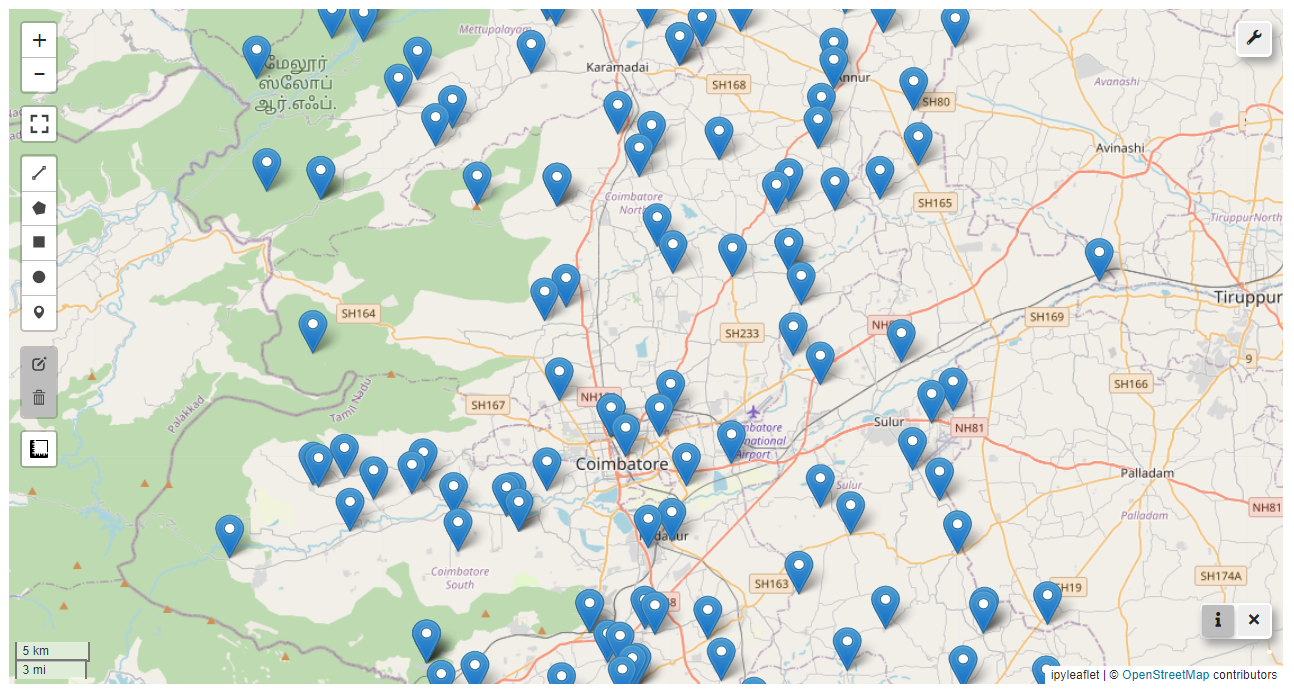

**3.2 As marker cluster**

In [33]:
d =  leafmap.Map(center=[0, 0], zoom=2)
d.add_points_from_xy(df_cb, x="long", y="lat")

In [ ]:
#d

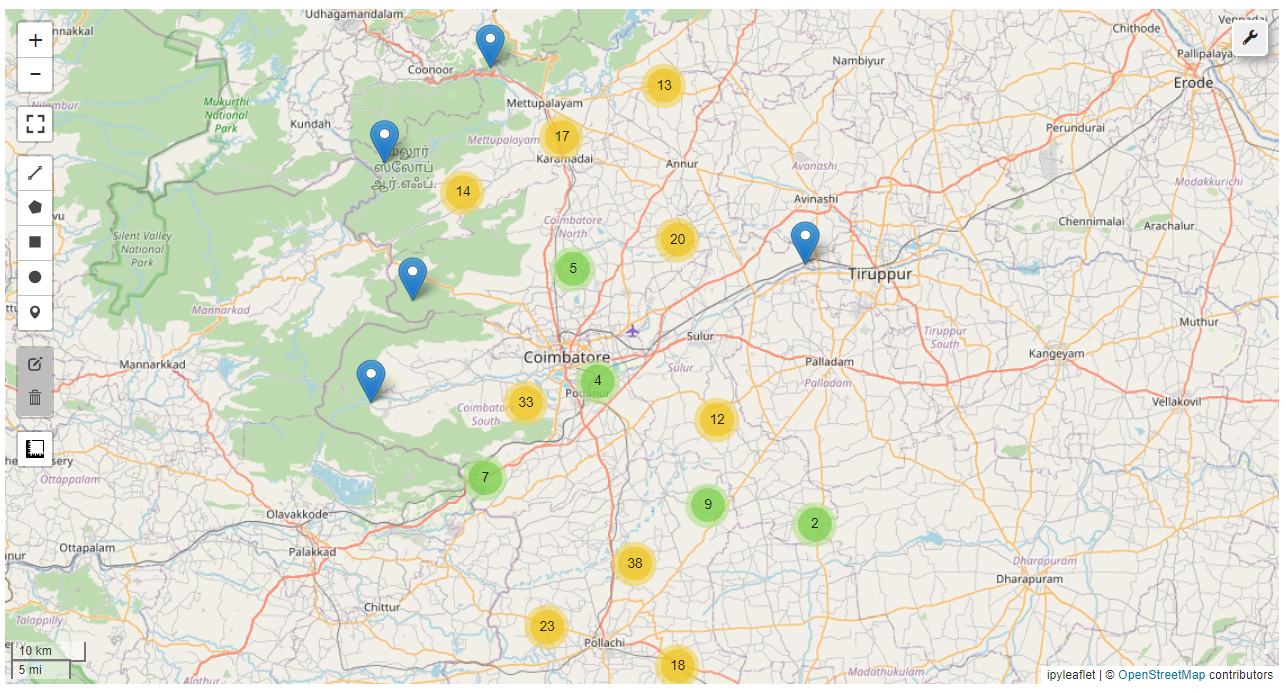

**4. Add layers to the map**

In [43]:
q = leafmap.Map(center=[0, 0], zoom=2)

# Add villages boundaries from census as 1st layer
q.add_gdf(df_c, layer_name="Villages boundaries")

# Add villages as 2nd layer
q.add_points_from_xy(df_cb, x="long", y="lat",layer_name="Villages")

In [ ]:
#q

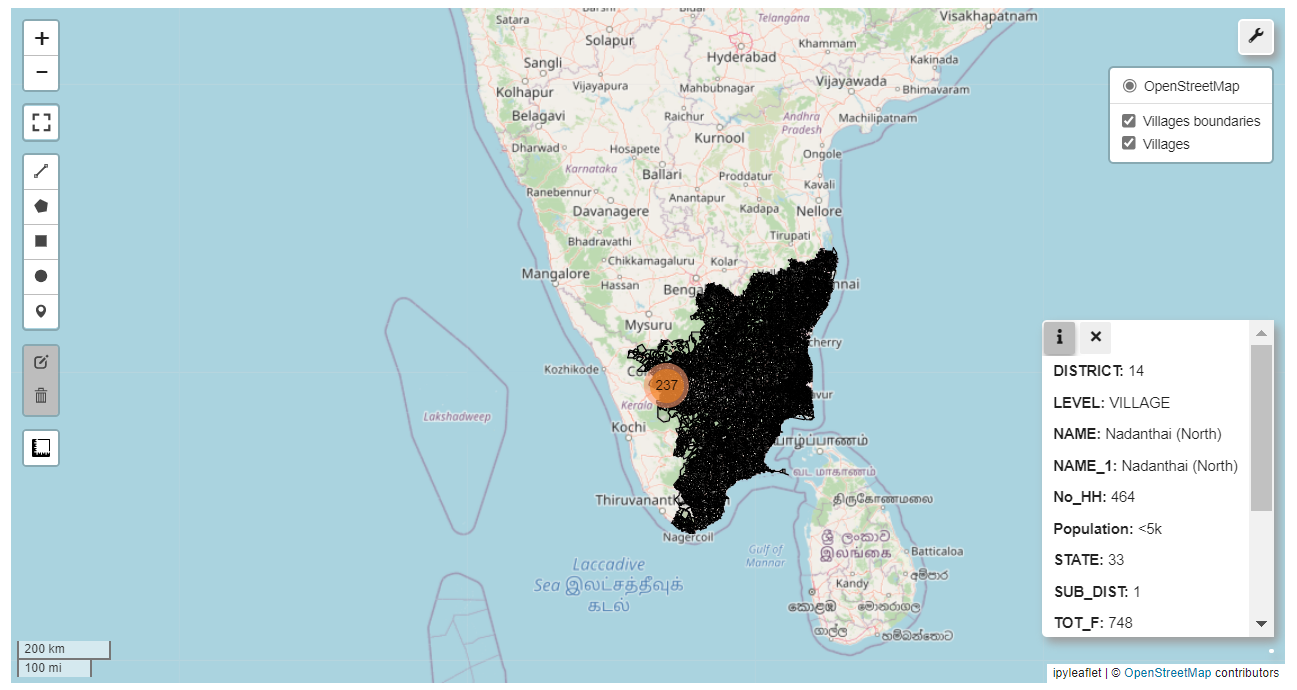

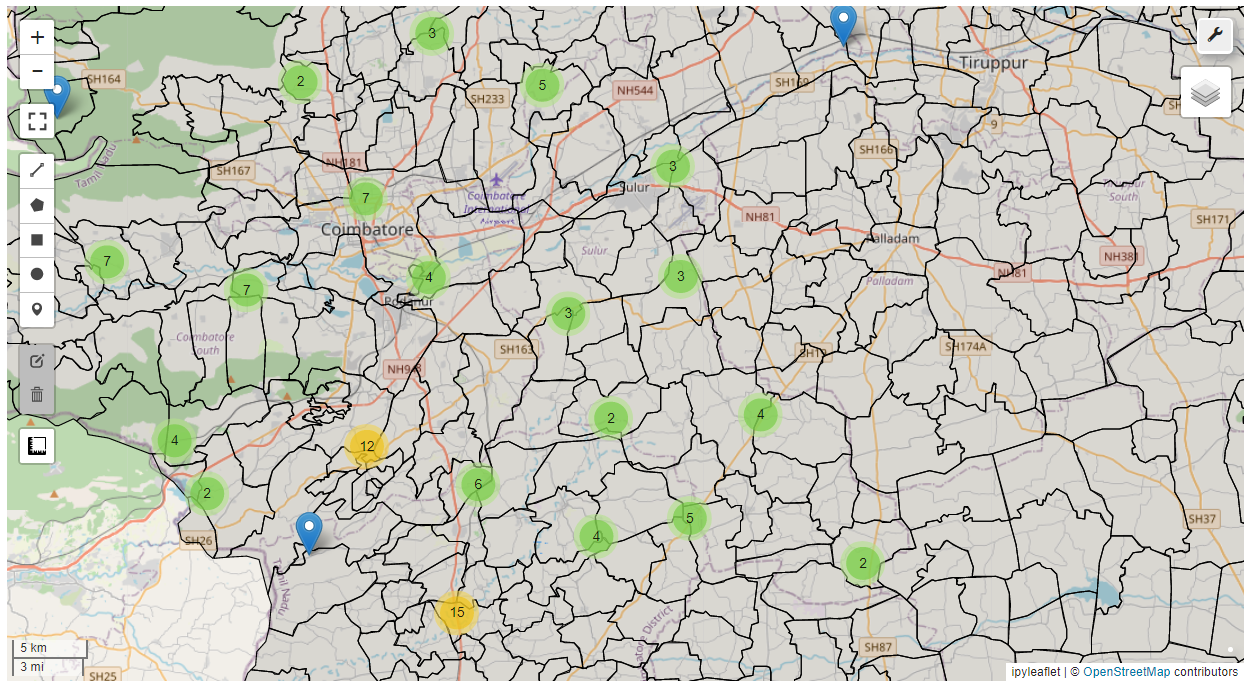

**5. Add color by values to the map**

<AxesSubplot:title={'center':'Population of TN'}>

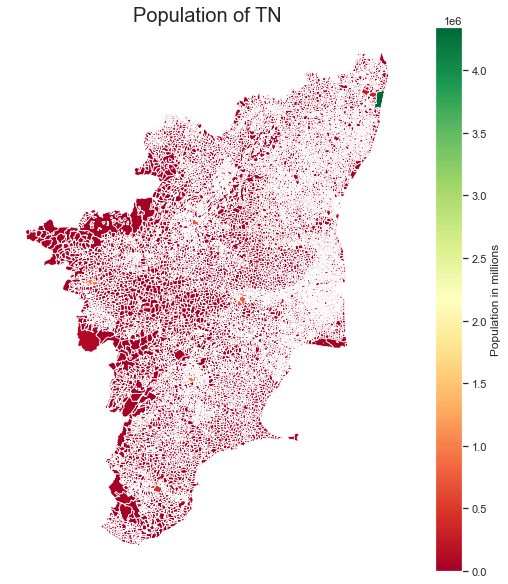

In [52]:
# PLot for state Tamil Nadu
#Create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Population of TN', fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
df_c.plot(column='TOT_P',label = 'TOT_P', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='1',legend=True, legend_kwds={'label': "Population in millions"})

<AxesSubplot:title={'center':'Population of Coimbatore'}>

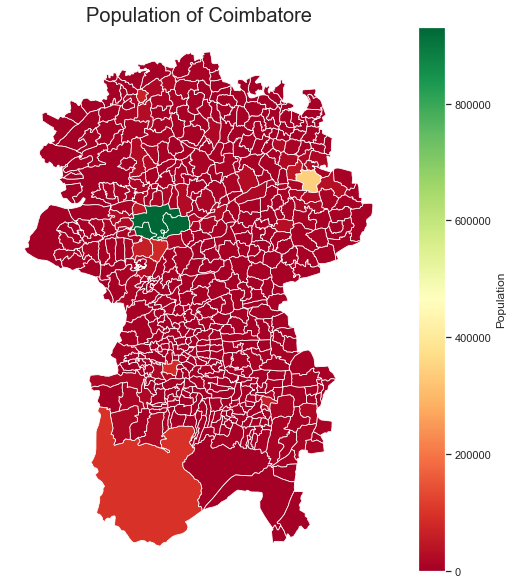

In [58]:
# PLot for district Coimbatore
#Create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Population of Coimbatore', fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
df_c[df_c['DISTRICT']==12].plot(column='TOT_P',label = 'TOT_P', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='1',legend=True, legend_kwds={'label': "Population"})